# KPtracer - mouse tumor evolution

We next apply PhyloVelo to a CRISPR/Cas9-based lineage tracing dataset from a genetically-engineered mouse model (GEMM) of lung adenocarcinoma (Kras LSL-G12D/+;Trp53 ﬂ/ﬂ, or KP model) described by Yang et al.  Cancer GEMMs allow one to study tumor evolutionary trajectory in its native microenvironment. Two primary tumors from KP mice (3726_NT_T1 and 3435_NT_T1) were selected because of their relatively high-resolution lineage trees and composition of diverse cell types (including AT2-like, AT1-like, Gastric-like, High plasticity, Lung-mixed, Endoderm-like, Early EMT-1, etc.) 

In [1]:
import phylovelo as pv

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from Bio import Phylo
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## import data

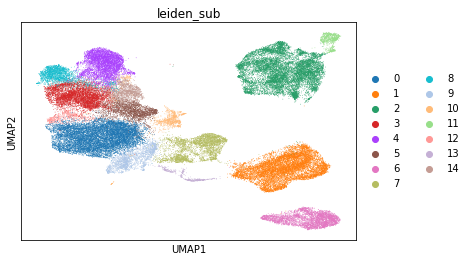

In [4]:
# Data is available at https://github.com/mattjones315/KPTracer-release.git
tree = Phylo.read('/home/wangkun/datas/KPTracer-Data/trees/3726_NT_T1_tree.nwk', format='newick')
adata = sc.read_h5ad("/home/wangkun/datas/KPTracer-Data/expression/adata_processed.nt.h5ad")
sigscores = pd.read_csv("/home/wangkun/KPTracer-release/reproducibility/Figure6_S6/data/fitness_signature_scores.tsv", sep='\t', index_col = 0)
sc.pl.umap(adata, color='leiden_sub')

In [5]:
kii = np.intersect1d(sigscores.index, adata.obs_names)
adata.obs['FitnessSignature'] = np.nan
adata.obs.loc[kii, 'FitnessSignature'] = sigscores.loc[kii, 'FitnessSignature_NT']

In [6]:
xdr = pd.DataFrame(data=adata.obsm['X_umap'], index=adata.obs.index)
c = adata.obs['leiden_sub'].astype(int)

## Filter cells 

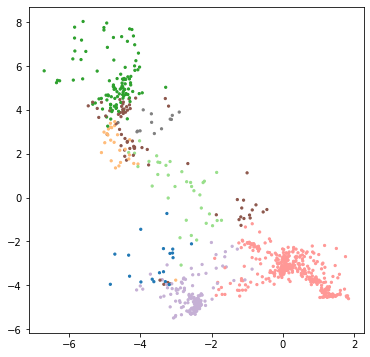

In [7]:
sel_cells = np.array([i.name for i in tree.get_terminals()])
sel_cells = sel_cells[np.isin(sel_cells, xdr.index)]
sel_xdr = xdr.loc[sel_cells]
cond = sel_xdr.iloc[:,0]<2
cond = cond & ~((sel_xdr.iloc[:,1]<3)&(sel_xdr.iloc[:,0]<-5.5))
cond = cond & ~((sel_xdr.iloc[:,1]<-5)&(sel_xdr.iloc[:,0]<1)&(sel_xdr.iloc[:,0]>-2))
sel_cells = sel_cells[cond]
sel_xdr = xdr.loc[sel_cells]
# plt.scatter(xdr.iloc[:,0], xdr.iloc[:,1], s=1)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(sel_xdr.iloc[:,0], sel_xdr.iloc[:,1], c=c[sel_cells].apply(lambda x: adata.uns['leiden_colors'][x]), s=5)

## Read data using scData

In [8]:
sel_data = adata[sel_cells]
sc.pp.filter_genes(sel_data, min_counts=10)
sd = pv.data_struct.scData(x_normed=sel_data.to_df(), phylo_tree=tree)
depths = [len(tree.get_path(sd.phylo_tree.find_any(name=i))) for i in sd.x_normed.index]
sd.Xdr = xdr.loc[sd.x_normed.index]

Trying to set attribute `.var` of view, copying.


## Inference and project velocity into embedding

In [10]:
sd = pv.inference.velocity_inference(sd, depths, cutoff=0.97, target='x_normed')
sd = pv.embedding.velocity_embedding(sd, target='x_normed')

/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:135: RuntimeWarning: invalid value encountered in double_scalars
  lr = 2 * (lh1 - lh0)


Text(-6, 6, 'AT2-like')

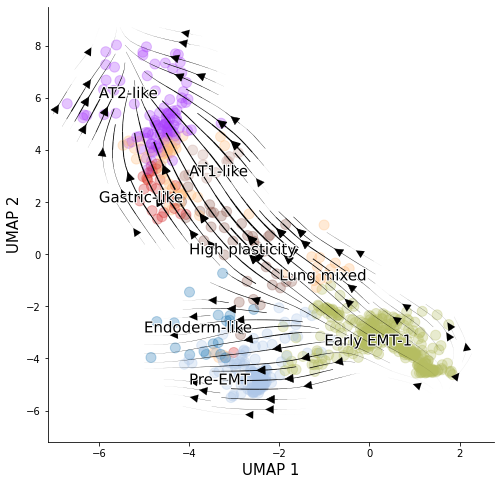

In [13]:
fig, ax = plt.subplots()
ax.scatter(sel_xdr.iloc[:,0], sel_xdr.iloc[:,1], 
           c=c[sel_cells].apply(lambda x: adata.uns['leiden_sub_colors'][x]), 
           s=100, alpha=0.3)
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream', radius=0.8, lw_coef=1500, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(-1, -3.5, 'Early EMT-1', fontsize=15,c='black',
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, -5, 'Pre-EMT', fontsize=15,c='black',
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-5, -3, 'Endoderm-like', fontsize=15,c='black',
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 0, 'High plasticity', fontsize=15,c='black',
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-2, -1, 'Lung mixed', fontsize=15,c='black',
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 2, 'Gastric-like', fontsize=15,c='black',
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 3, 'AT1-like', fontsize=15,c='black',
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 6, 'AT2-like', fontsize=15,c='black',
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])

## Inference PhyloVelo pseudotime

In [14]:
sd = pv.pseudo_time.calc_phylo_pseudotime(sd, n_neighbors=100, r_sample=0.8)

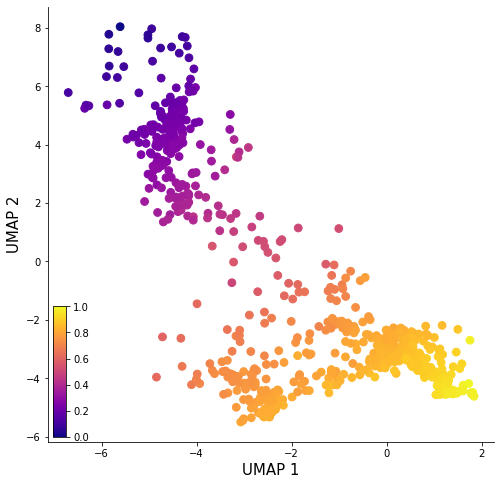

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(sd.Xdr.iloc[:,0],sd.Xdr.iloc[:,1], c=sd.phylo_pseudotime,cmap='plasma', s=60)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower left') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

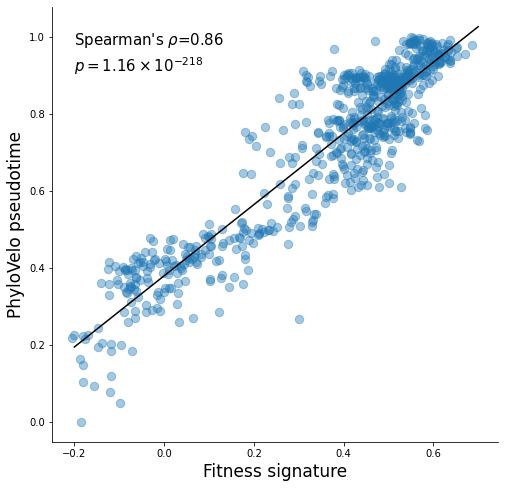

In [18]:
x = adata.obs['FitnessSignature'][sd.Xdr.index][~np.isnan(adata.obs['FitnessSignature'][sd.Xdr.index])]
y = sd.phylo_pseudotime[~np.isnan(adata.obs['FitnessSignature'][sd.Xdr.index])]

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(-0.2,0.7,60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(-0.2,0.7,60), y_est, '-', c='k')
ax.set_xlabel('Fitness signature', fontsize=17)
ax.set_ylabel('PhyloVelo pseudotime', fontsize=17)
# ax.text(50, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(-0.2, 0.98, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(-0.2, 0.91, r'$p={}\times 10^{}$'.format(*r'{:.2e}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
# ax.set_ylim(-0.05,0.7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Show gene expression heatmap

In [23]:
from sklearn.preprocessing import scale
import seaborn as sns

gene_vel_map = pd.DataFrame(data=sd.velocity, index=sd.x_normed.columns)

corrs = []
genelist = []
for i in list(gene_vel_map.index[sd.velocity!=0]):
    genelist.append(i)
    x = np.array(depths)
    y = sd.x_normed[i]
    corrs.append(spearmanr(x,y)[0])
corrs = np.array(corrs)
genelist = np.array(genelist)

genes1 = genelist[corrs>0]
genes2 = genelist[corrs<0]

genes1 = genes1[np.argsort(scale(sd.x_normed[genes1], axis=0).sum(0))]
genes2 = genes2[np.argsort(scale(sd.x_normed[genes2], axis=0).sum(0))]
genes1 = genes1[::-1]


genetraj1 = []
for i in genes1:
    genetraj1.append(scale(list(sd.x_normed[i][np.argsort(sd.phylo_pseudotime)])))
genetraj1 = np.array(genetraj1)

genetraj2 = []
for i in genes2:
    genetraj2.append(scale(list(sd.x_normed[i][np.argsort(sd.phylo_pseudotime)])))
genetraj2 = np.array(genetraj2)

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be 

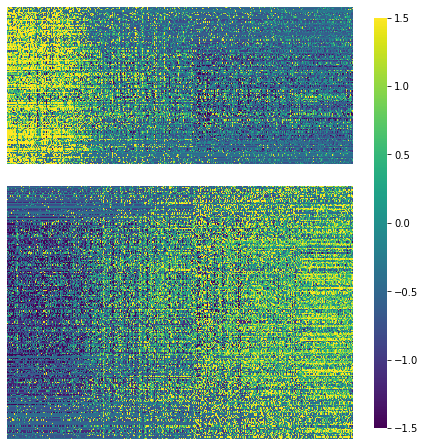

In [36]:
fig = plt.figure(figsize=(6, 6))
h1 = len(genes1)/(len(genes1)+len(genes2))
h2 = len(genes2)/(len(genes1)+len(genes2))
ax1 = plt.axes([0.05, 0, 0.8, 0.95*h1])
ax2 = plt.axes([0.05, 0.95*h1+0.05, 0.8, 0.95*h2])
ax3 = plt.axes([0.9,0.025,0.03,0.95])

ax1 = sns.heatmap(genetraj1, cmap='viridis', ax=ax1, cbar_ax=ax3,vmax=1.5, vmin=-1.5, xticklabels=False, yticklabels='')
ax2 = sns.heatmap(genetraj2[::-1], cmap='viridis', ax=ax2, cbar=False,vmax=1.5, vmin=-1.5, xticklabels=False, yticklabels='')


## Transfer phylogenetic velocity to more data

In [33]:
sel_cells = adata.obs['Cluster-Name'][np.isin(adata.obs['Cluster-Name'], 
                                              ['AT1-like', 'AT2-like', 'Early gastric','Gastric-like','Late Gastric',
                                               'High plasticity','Lung progenitor-like','Endoderm-like','Early EMT-1', 'Pre-EMT'])].index

In [34]:
sd_early.count = adata.count.loc[sel_cells]
sd_early.x_normed = sd_early.x_normed.loc[sel_cells]
sd_early.Xdr = sd_early.Xdr.loc[sel_cells]

In [69]:
sd_early = velocity_embedding(sd_early, target='x_normed', n_neigh=300)

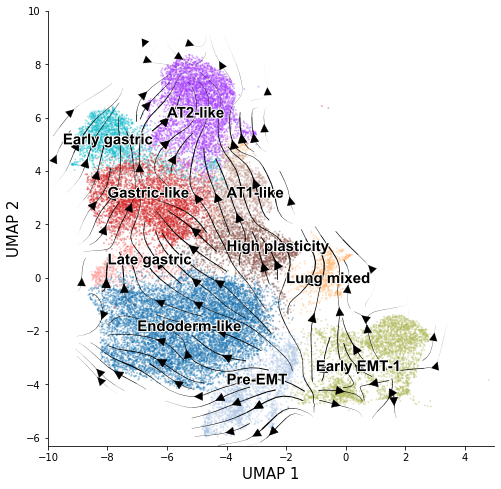

In [43]:
fig, ax = plt.subplots()
ax.scatter(sd_early.Xdr.iloc[:,0], sd_early.Xdr.iloc[:,1], 
           c=c[sd_early.Xdr.index].apply(lambda x: adata.uns['leiden_sub_colors'][x]), 
           s=1, alpha=0.3)
ax = velocity_plot(sd_early.Xdr.to_numpy(), sd_early.velocity_embeded, ax, 'stream', radius=0.5, lw_coef=16000, streamdensity=1.5, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-6.3, 10)
ax.set_xlim(-10, 5)

ax.text(-1, -3.5, 'Early EMT-1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, -4, 'Pre-EMT', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-7, -2, 'Endoderm-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 1, 'High plasticity', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-2, -0.2, 'Lung mixed', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-8, 3, 'Gastric-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 3, 'AT1-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 6, 'AT2-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-9.5, 5, 'Early gastric', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-8, 0.5, 'Late gastric', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])

In [67]:
sd_all = scData(count=pd.DataFrame(data=adata.X.A, index=adata.obs_names, columns=adata.var_names), Xdr=pd.DataFrame(data=adata.obsm['X_umap'], index=adata.obs_names))

In [68]:
sd_all.count = sd_all.count[sd.x_normed.columns]
sd_all.x_normed = sd_all.count
sd_all.velocity = sd.velocity

In [ ]:
sd_all = velocity_embedding(sd_all, target='x_normed', n_neigh=300)

Text(5, -11, 'Mesenchymal-2 (Met)')

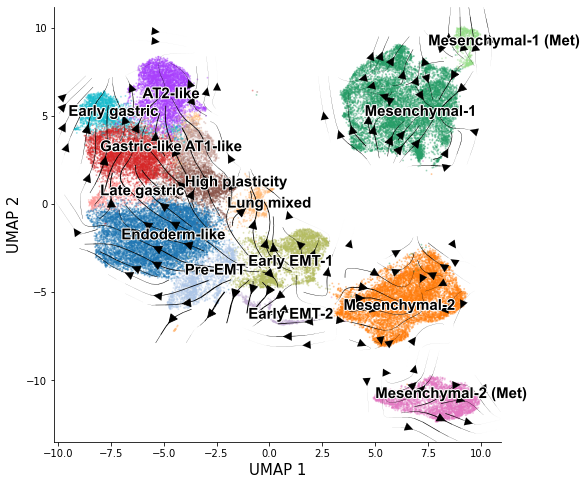

In [70]:
fig, ax = plt.subplots()
ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], 
           c=[adata.uns['leiden_sub_colors'][x] for x in c[adata.obs_names]], 
           s=1, alpha=0.3)
ax = velocity_plot(sd_all.Xdr.to_numpy(), sd_all.velocity_embeded, ax, 'stream', radius=0.5, lw_coef=16000, streamdensity=1.5, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(-1, -3.5, 'Early EMT-1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, -4, 'Pre-EMT', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-7, -2, 'Endoderm-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 1, 'High plasticity', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-2, -0.2, 'Lung mixed', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-8, 3, 'Gastric-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 3, 'AT1-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 6, 'AT2-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-9.5, 5, 'Early gastric', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-8, 0.5, 'Late gastric', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])

ax.text(-1, -6.5, 'Early EMT-2', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(3.5, -6, 'Mesenchymal-2', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(4.5, 5, 'Mesenchymal-1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(7.5, 9, 'Mesenchymal-1 (Met)', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(5, -11, 'Mesenchymal-2 (Met)', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])